<a href="https://colab.research.google.com/github/MateoProjects/TFM/blob/main/Stable_Diffusion_TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements

In [8]:
!pip install diffusers==0.2.3 transformers scipy ftfy
!pip install "ipywidgets>=7,<8"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Login

In [9]:
from google.colab import output
output.enable_custom_widget_manager()
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Download model

In [10]:
from torch import autocast
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler
import torch
# this will substitute the default PNDM scheduler for K-LMS  
lms = LMSDiscreteScheduler(
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule="scaled_linear"
)

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")







In [11]:
#StableDiffusionPipeline.save_pretrained(pipe, save_directory=".")
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Prompt images

In [12]:
#@title Inputs {display-mode: "form" }
imagine = 'A samurai' #@param {type:"string"}
style = 'Oil painting' #@param ["Oil painting", "Cosmic", "Sinister", "Anime", "Manga", "Fantasy"]
other = '' #@param {type:"string"}
num_images = 3 #@param {type:"integer"}
rows = 1 #@param {type:"integer"}
cols = 3 #param {type:"integer"}

prompt = "% s % s % s"%(imagine, style, other)


0it [00:00, ?it/s]

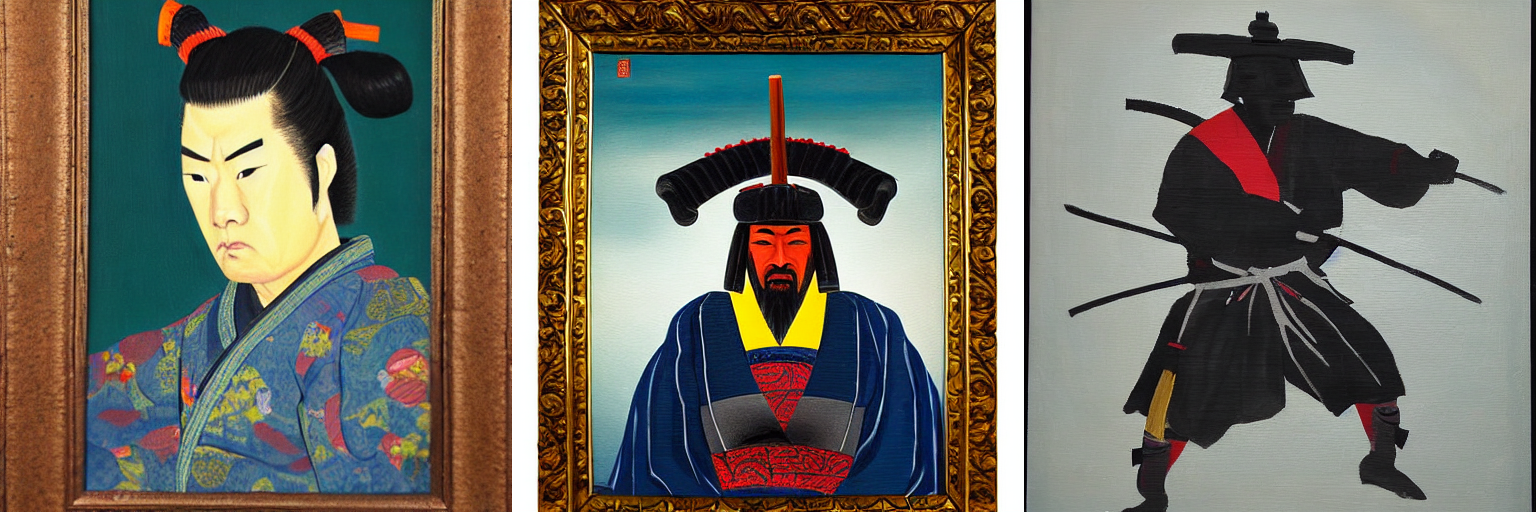

In [13]:
#@title Push play for imagine  {display-mode: "form"}
prompt = [prompt] * num_images

with autocast("cuda"):
  images = pipe(prompt)["sample"]

grid = image_grid(images, rows=rows, cols=cols)
grid
#images[0]